# Evaluation

## OKS per frame for video

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from visualization import oks_plot, dataset_path
import ipywidgets as widgets
from ipywidgets import VBox, HBox, Output, GridBox, Layout
from IPython.display import display
from PIL import Image

In [2]:
# Load CSV data into a DataFrame
df = pd.read_csv('data/results/results.csv')

# Set Seaborn style
sns.set_theme(style="white")


# Create output widgets to capture the plot and image
output = Output()
image_output = Output(layout=Layout(width="1000px", border='0px solid black'))

output_container = widgets.Box([output], layout=Layout(width='1000px'))

# Define a function to update the plot and display it in the output widget
def update_plot(dataset, video, number_of_id, bin_size, frames):
    with output:
        output.clear_output()
        try:
            oks_plot(dataset, video, number_of_id, bin_size, frames)
        except Exception as e:
            print(f"An error occurred while generating the plot: {e}")

# Define a function to show the images from the specified frames and add OKS value to the graph
def show_frames(frame_numbers, dataset, video):
    with image_output:
        image_output.clear_output()

        if not frame_numbers:
            print("No frames to display.")
            return

        num_cols = 3
        num_rows = (len(frame_numbers) + num_cols - 1) // num_cols
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))
        
        # Ensure axes is always a 2D array
        if num_rows == 1:
            axes = [axes]
        if num_cols == 1:
            axes = [[ax] for ax in axes]
        
        axes = [ax for row in axes for ax in row]  # Flatten the 2D array
        
        for ax in axes:
            ax.axis('off')  # Turn off axis

        for i, frame_number in enumerate(frame_numbers):
            image_path = f'{dataset_path}/{dataset}/hdImgs/{video}/{video}_{frame_number:08d}.jpg'
            try:
                img = Image.open(image_path)
                axes[i].imshow(img)
                axes[i].set_title(f'Frame {frame_number}')
                axes[i].axis('off')  # Turn on axis for used axes
            except FileNotFoundError:
                print(f"Frame {frame_number} not found.")
        
        plt.tight_layout()
        plt.show()

# Create interactive controls
dataset_widget = widgets.Text(value='160906_band2', description='Dataset:', continuous_update=False, layout=Layout(grid_area='dataset'))
video_widget = widgets.Text(value='00_00', description='Video:', continuous_update=False, layout=Layout(grid_area='video'))
number_of_id_widget = widgets.IntText(value=0, description='ID:', continuous_update=False, layout=Layout(grid_area='id'))
bin_size_widget = widgets.IntSlider(min=10, max=200, step=10, value=100, description='Bin Size:', continuous_update=False, layout=Layout(grid_area='bin_size'))
frame_numbers_widget = widgets.Text(value='1 2', description='Frame Numbers (comma-separated):', continuous_update=False)

# Create controls for frame number and show button
show_button = widgets.Button(description='Show')

# Arrange the controls in a grid layout
grid = GridBox(children=[dataset_widget, video_widget, number_of_id_widget, bin_size_widget],
               layout=Layout(
                   width='50%',
                   grid_template_columns='repeat(1, 1fr)',
                   grid_template_rows='auto auto',
                   grid_template_areas='''
                   "dataset video"
                   "id  bin_size"                   
                   '''
               ))

# Define the action for the show button
def on_show_button_click(b):
    frame_numbers = list(map(int, frame_numbers_widget.value.replace(',', ' ').split()))
    try:
        show_frames(frame_numbers, dataset_widget.value, video_widget.value)
    except Exception as e:
        frame_numbers = []
    update_plot(dataset_widget.value, video_widget.value, number_of_id_widget.value, bin_size_widget.value, frame_numbers)

show_button.on_click(on_show_button_click)

# Display the controls and output
display(VBox([    
    HBox([grid]),    
    HBox([frame_numbers_widget, show_button]),
    HBox([output_container]),
    HBox([image_output])    
]))

# Load the default image on initialization
on_show_button_click(None)

# Precision and Recall 

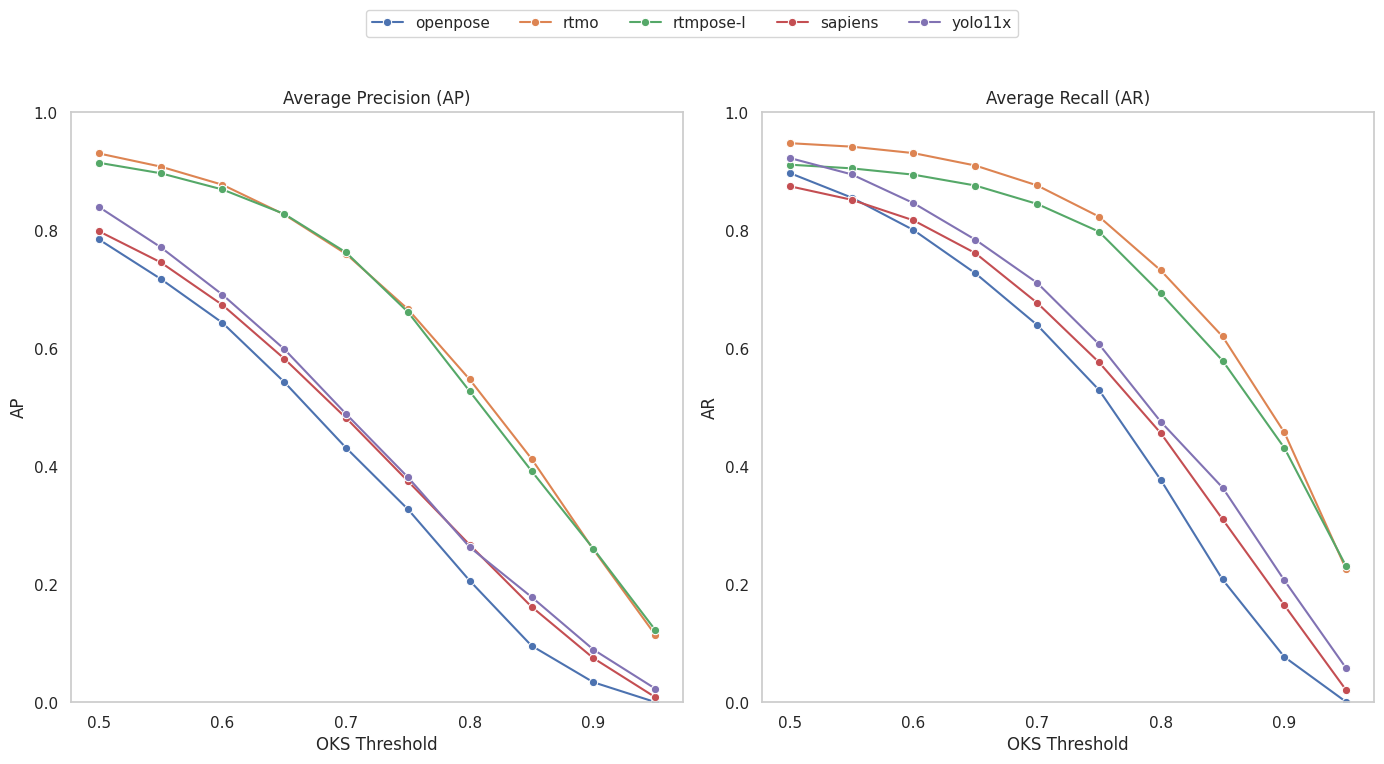

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize an empty DataFrame to store AP and AR values
AP_AR = pd.DataFrame(columns=['method', 'AP', 'AR', 'OKS'])

# Loop through the thresholds and read the corresponding CSV files
for i in range(10):
    threshold = round(0.5 + i * 0.05, 2)
    data = pd.read_csv(f'dataset/results/results_precision_recall/precision_recall_{threshold}.csv', index_col=0)
    
    # Group data by 'method' and calculate mean precision (AP) and recall (AR)
    grouped_data = data.groupby('method').agg({'precision': 'mean', 'recall': 'mean'}).reset_index()
    grouped_data['OKS'] = threshold
    
    # Append the results to the AP_AR DataFrame
    AP_AR = pd.concat([AP_AR, grouped_data.rename(columns={'precision': 'AP', 'recall': 'AR'})], ignore_index=True)

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot Average Precision (AP)
sns.lineplot(data=AP_AR, x='OKS', y='AP', hue='method', marker='o', ax=axes[0])
axes[0].set_title('Average Precision (AP)')
axes[0].set_xlabel('OKS Threshold')
axes[0].set_ylabel('AP')
axes[0].set_ylim(0, 1)
axes[0].grid(False)

# Plot Average Recall (AR)
sns.lineplot(data=AP_AR, x='OKS', y='AR', hue='method', marker='o', ax=axes[1])
axes[1].set_title('Average Recall (AR)')
axes[1].set_xlabel('OKS Threshold')
axes[1].set_ylabel('AR')
axes[1].set_ylim(0, 1)
axes[1].grid(False)

# Remove individual legends
axes[0].legend_.remove()
axes[1].legend_.remove()

# Create a single legend for both plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()